# Wilson's Morning Wake Up Playlist Generator, Modeling and Learning

## Local

In [15]:
# Defaults
import os
import sys

import pandas as pd
import numpy as np
import random

from scipy.spatial.distance import cdist
from tqdm.notebook import tqdm

import torch
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
import joblib
import config

%matplotlib inline

In [16]:
!ls -la data

'ls' is not recognized as an internal or external command,
operable program or batch file.


## Ingest Data

In [17]:
# should be the name of directory you created to save your features data
data_dir = 'data'

In [18]:
from model import PlaylistDataset

dataset =  PlaylistDataset.PlaylistDataset(data_dir, "tensor_train.csv")

dataloader = DataLoader(dataset, batch_size=12, shuffle=False)

---

# Modeling

It's time to define and train the models!

---


# Create an Estimator

## Define PyTorch estimators

### Test run of benchmark and candidate models and train components
Here I will see if the configurations I have set work accordingly with no errors. Once it runs smoothly, I will instantiate the estimators using the Sagemaker API in the AWS notebook.

I define the train function for training the baseline RNN model and candidate, LSTM model. Each model excepts a tensor of 9 features. For feed-forward behaviour, a single track - as input - along with with a hidden state is accepted, which is then used to predict the features of the following track.

In [19]:
# Training function for LSTM
def train(model, train_loader, epochs, criterion, optimizer, device):
    """
    This is the training method that is called by the PyTorch training script of the LSTM model. The parameters
    passed are as follows:
    model        - The PyTorch model that we wish to train.
    train_loader - The PyTorch DataLoader that should be used during training.
    epochs       - The total number of epochs to train for.
    criterion    - The loss function used for training. 
    optimizer    - The optimizer to use during training.
    device       - Where the model and data should be loaded (gpu or cpu).
    """
    
    model.train() # Make sure that the model is in training mode.
    
    for epoch in range(1, epochs + 1):
        
        avg_loss = 0
        
        # Iterate over dataset
        for i, batch in enumerate(train_loader):
            
            # Clear stored gradient
            optimizer.zero_grad()
            
            # Initialize hidden state 
            hidden_cell = model.init_hidden()
            
            # Batch of 12 tracks
            batch_x = batch[0] # X input
            batch_y = batch[-1] # y target
            
            # Forward pass
            output, hidden_cell = model(batch_x.unsqueeze(0), hidden_cell)
            
            # Calculate MAE loss over batch
            batch_loss = criterion(output.squeeze(0), batch_y)
            avg_loss += batch_loss.item()
            
            # Zero out gradient, so it doesnt accumulate between epochs
            optimizer.zero_grad()

            # Backward pass
            batch_loss.backward()

            # Update parameters
            optimizer.step()
        
        loss_record.append(avg_loss / len(train_loader))
        
        if epoch % 50 == 0:
            print('Epoch: {}/{}.............'.format(epoch, epochs), end=' ')
            print("Loss: {:.4f}".format(avg_loss / len(train_loader)))

In [72]:
num_epochs = 10000

### Baseline: Recurrent neural network model

In [73]:
# Directory of RnnEstimator.py
!pygmentize model/RNNEstimator.py

# torch imports
import torch
import torch.nn.functional as F
import torch.nn as nn


class RNNEstimator(nn.Module):
    """
    RNN Estimator for generating sequences of target variables.
    """
    
    def __init__(self, input_features=9, hidden_dim=12, n_layers=2, output_dim=9, batch_size=12):
        super(RNNEstimator, self).__init__()

        self.hidden_dim = hidden_dim
        self.hidden_layers = n_layers
        self.batch_size = batch_size
        
        # RNN Layer
        self.rnn = nn.RNN(input_features, hidden_dim, n_layers, dropout=0.3)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    ## Initialize the hidden and cell states of the LSTM with zeros.
    def init_hidden(self):
        return torch.zeros(self.hidden_layers, self.batch_size, self.hidden_dim)
        
    ## Define the feedforward behavior of the network
    def forward(self, input, hidden_state):
        
        # Passing in the input and hidden 

In [74]:
%time

from model.RNNEstimator import RNNEstimator

loss_record = [] # Store loss after each epoch for visualization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
rnn_model = RNNEstimator(9, 12, 2, 9)
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

train(rnn_model, dataloader, num_epochs, loss_fn, optimizer, device)

Wall time: 0 ns
Epoch: 50/10000............. Loss: 0.6229
Epoch: 100/10000............. Loss: 0.6187
Epoch: 150/10000............. Loss: 0.6176
Epoch: 200/10000............. Loss: 0.6129
Epoch: 250/10000............. Loss: 0.6093
Epoch: 300/10000............. Loss: 0.6106
Epoch: 350/10000............. Loss: 0.6064
Epoch: 400/10000............. Loss: 0.6057
Epoch: 450/10000............. Loss: 0.6081
Epoch: 500/10000............. Loss: 0.6054
Epoch: 550/10000............. Loss: 0.6029
Epoch: 600/10000............. Loss: 0.6014
Epoch: 650/10000............. Loss: 0.5944
Epoch: 700/10000............. Loss: 0.5998
Epoch: 750/10000............. Loss: 0.5984
Epoch: 800/10000............. Loss: 0.6004
Epoch: 850/10000............. Loss: 0.6038
Epoch: 900/10000............. Loss: 0.5974
Epoch: 950/10000............. Loss: 0.5992
Epoch: 1000/10000............. Loss: 0.5994
Epoch: 1050/10000............. Loss: 0.5988
Epoch: 1100/10000............. Loss: 0.5954
Epoch: 1150/10000............. Loss:

Epoch: 9400/10000............. Loss: 0.5833
Epoch: 9450/10000............. Loss: 0.5823
Epoch: 9500/10000............. Loss: 0.5824
Epoch: 9550/10000............. Loss: 0.5744
Epoch: 9600/10000............. Loss: 0.5837
Epoch: 9650/10000............. Loss: 0.5786
Epoch: 9700/10000............. Loss: 0.5819
Epoch: 9750/10000............. Loss: 0.5782
Epoch: 9800/10000............. Loss: 0.5775
Epoch: 9850/10000............. Loss: 0.5805
Epoch: 9900/10000............. Loss: 0.5776
Epoch: 9950/10000............. Loss: 0.5805
Epoch: 10000/10000............. Loss: 0.5835


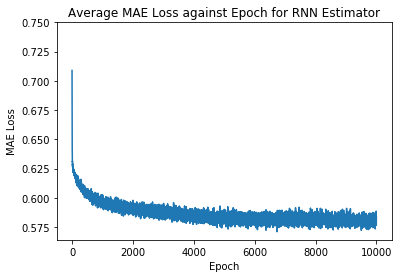

In [75]:
# RNN Loss Plot
x = range(1, len(loss_record) + 1)
y = loss_record

plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Average MAE Loss against Epoch for RNN Estimator")
plt.ylim(top=0.75)
plt.savefig("img/RNN" + "_" + str(num_epochs) +'.png') # Save diagram
plt.show()

In [83]:
# Save RNN
torch.save(rnn_model.state_dict(), 'artefacts/rnn_model.pth')

### Candidate: Long short-term memory model

In [77]:
# Directory of LstmEstimator.py
!pygmentize model/LstmEstimator.py

# torch imports
import torch
import torch.nn.functional as F
import torch.nn as nn


class LSTMEstimator(nn.Module):
    """
    LSTM Estimator for generating sequences of target variables.
    """

    def __init__(self, input_features=9, hidden_dim=12, n_layers=2, output_dim=9, batch_size=12):
        """s
        Initialize the model by setting up linear layers.
        Use the input parameters to help define the layers of your model.
        :param input_features: the number of input features in your training/test data
        :param hidden_dim: helps define the number of nodes in the hidden layer(s)
        :param output_dim: the number of outputs you want to produce
        """
        super(LSTMEstimator, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.hidden_layers = n_layers
        self.batch_size = batch_size

        # The LSTM takes track features as inputs, and outputs hidden states
        # with dimensionality hidden_dim
        self.lstm = n

In [78]:
%time

from model.LSTMEstimator import LSTMEstimator

loss_record = [] # Store loss after each epoch for visualization

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lstm_model = LSTMEstimator(9, 12, 2, 9)
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
loss_fn = torch.nn.L1Loss()

train(lstm_model, dataloader, num_epochs, loss_fn, optimizer, device)

Wall time: 0 ns
Epoch: 50/10000............. Loss: 0.6170
Epoch: 100/10000............. Loss: 0.6065
Epoch: 150/10000............. Loss: 0.5974
Epoch: 200/10000............. Loss: 0.5944
Epoch: 250/10000............. Loss: 0.5900
Epoch: 300/10000............. Loss: 0.5876
Epoch: 350/10000............. Loss: 0.5803
Epoch: 400/10000............. Loss: 0.5768
Epoch: 450/10000............. Loss: 0.5771
Epoch: 500/10000............. Loss: 0.5763
Epoch: 550/10000............. Loss: 0.5741
Epoch: 600/10000............. Loss: 0.5730
Epoch: 650/10000............. Loss: 0.5680
Epoch: 700/10000............. Loss: 0.5613
Epoch: 750/10000............. Loss: 0.5590
Epoch: 800/10000............. Loss: 0.5650
Epoch: 850/10000............. Loss: 0.5568
Epoch: 900/10000............. Loss: 0.5571
Epoch: 950/10000............. Loss: 0.5555
Epoch: 1000/10000............. Loss: 0.5611
Epoch: 1050/10000............. Loss: 0.5544
Epoch: 1100/10000............. Loss: 0.5567
Epoch: 1150/10000............. Loss:

Epoch: 9400/10000............. Loss: 0.5098
Epoch: 9450/10000............. Loss: 0.5134
Epoch: 9500/10000............. Loss: 0.5079
Epoch: 9550/10000............. Loss: 0.5085
Epoch: 9600/10000............. Loss: 0.5054
Epoch: 9650/10000............. Loss: 0.5103
Epoch: 9700/10000............. Loss: 0.5019
Epoch: 9750/10000............. Loss: 0.5108
Epoch: 9800/10000............. Loss: 0.5073
Epoch: 9850/10000............. Loss: 0.5062
Epoch: 9900/10000............. Loss: 0.5094
Epoch: 9950/10000............. Loss: 0.5076
Epoch: 10000/10000............. Loss: 0.5109


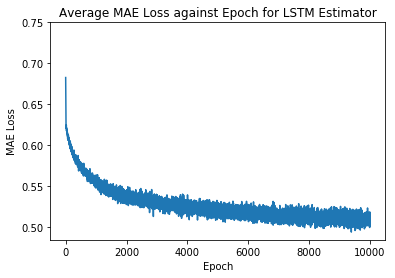

In [79]:
# LSTM Loss Plot
x = range(1, len(loss_record) + 1)
y = loss_record

plt.plot(x, y)
plt.xlabel("Epoch")
plt.ylabel("MAE Loss")
plt.title("Average MAE Loss against Epoch for LSTM Estimator")
plt.ylim(top=0.75)
plt.savefig("img/LSTM" + "_" + str(num_epochs) +'.png') # Save diagram
plt.show()

In [82]:
# Save LSTM
torch.save(lstm_model.state_dict(), 'artefacts/lstm_model.pth')

## Pipeline

Now I setup a session using the Spotipy API then define the Playlist class for pooling together tracks, acquiring recommendations, and generating a playlist using one of the models trained above. When running the main function, a Playlist object is initialized and the constructor generates a playlist. The playlist is then posted to my Spotify profile.

In [81]:
# Spotify API
import spotipy
import spotipy.util as util

# Spotify for developers client auth variables
username = os.environ['SPOTIFY_EMAIL']
spotify_id = os.environ['SPOTIFY_ID']
spotify_secret = os.environ['SPOTIFY_SECRET']

# Set API scope
scope='playlist-read-private, playlist-modify-private, playlist-modify-public'

# Get auth token
token = util.prompt_for_user_token(username, 
                                   scope,
                                   client_id=spotify_id,
                                   client_secret=spotify_secret,
                                   redirect_uri='http://localhost/')

KeyError: 'SPOTIFY_EMAIL'

In [ ]:
from spotipy.oauth2 import SpotifyClientCredentials

#Authenticate
sp = spotipy.Spotify(
    client_credentials_manager = SpotifyClientCredentials(
        client_id=spotify_id,
        client_secret=spotify_secret
    )
)

In [ ]:
# Read in WMW tracks to date for recommendations
track_data = pd.read_csv(os.path.join(data_dir, "wmw_tracks.csv"))

track_data.head()

### Playlist Class

In [ ]:
class Playlist():
    def __init__(self, wmw_pool, spotify_auth, spotify_token, model_type="LSTM"):
        """ Initiates pool of historic tracks, spotify api authentication and 
            model of choice.
        """
        self.recommended_track_ids = pd.DataFrame() #list of track ids straight from spotify
        self.trax = [] #all tracks as dict
        self.df = None #this is where the data goes
        self.playlist = None
        self.wmw_pool_df = wmw_pool
        self.token = spotify_token
        self.spotify_auth = spotify_auth

        # Feature set
        self.feature_list =  ['danceability','energy', 'loudness', 'speechiness', 'acousticness',
                         'instrumentalness', 'liveness', 'valence', 'tempo']

        # Setup feature standardisation
        self.std_scaler = joblib.load('artefacts/standard_features.pkl')

        # Setup dimensionality reduction for track picking
        self.dim_red = joblib.load('artefacts/dim_red.pkl')

        if model_type == "LSTM":
            model = LstmEstimator(9, 30, 1, 9)
            model.load_state_dict(torch.load('artefacts/lstm_model.pth'))

        elif model_type == "RNN":
            model = RnnEstimator(9, 30, 9)
            model.load_state_dict(torch.load('artefacts/rnn_model.pth'))
        else:
            print("Please specify either the RNN or LSTM model using the model_type parameter.")

        model.eval()

        # Start building the new playlist
        self.intro_track = self.get_first_track()
        self.new_playlist = self.predict_playlist(model, self.intro_track)


    def get_first_track(self):
        """Get first track based on recommendations."""
        # Sample an intro song from the WMW history
        song = self.wmw_pool_df[self.wmw_pool_df['position'] == 1].sample(1).copy()

        # Gather a recommendation based on the intro track using spotify
        song_res = self.spotify_auth.recommendations(seed_tracks=song['id'].values, limit=1)

        # Gather track freatures from spotify result
        for r in song_res['tracks']:
            track = {'id': r['id'], 'artists': ([i['name'] for i in r['artists']],), 'name': r['name']}
            track_features = self.spotify_auth.audio_features(r['id'])[0]
            track.update(track_features)
            self.intro_track = pd.DataFrame(track, index=[0])

        # Prepare features
        self.intro_track[self.feature_list] = self.std_scaler.transform(self.intro_track[self.feature_list])

        return self.intro_track

    def harmonic_match(self, key, mode):
        """Given a key and mode, return compatible keys according to the harmonic wheel."""

        # Harmonic Mixing Wheel: Pitch Class 
        # 1A 0 - A flat minor: 8 | 1B 0 - B major: 11
        # 2A 1 - E flat minor: 3 | 2B 1 - F-sharp major: 6
        # 3A 2 - B-flat minor: 10 | 3B 2 - D-flat major: 1
        # 4A 3 - F minor: 5 | 4B 3 - A-flat major: 8
        # 5A 4 - C minor: 0 | 5B 4 - E-flat major: 3
        # 6A 5 - G minor: 7 | 6B 5 - B-flat major: 10
        # 7A 6 - D minor: 2 | 7B 6 - F major: 5
        # 8A 7 - A minor: 9 | 8B 7 - C major: 0
        # 9A 8 - E minor: 4 | 9B 8 - G major: 7
        # 10A 9 - B minor: 11 | 10B 9 - D major: 2
        # 11A 10 - F sharp minor: 6 | 11B 10 - A major: 9
        # 12A 11 - D flat minor: 1 | 12B 11 - E major: 4

        # Harmonic keys mapped to corresponding pitch classes
        pitch_to_harmonic_keys = {0: [4, 7], 1: [11, 2], 2: [6, 9],
                                  3: [1, 4], 4: [8, 11], 5: [3, 6],
                                  6: [10, 1], 7: [5, 8], 8: [0, 3],
                                  9: [7, 10], 10: [2, 5], 11: [9, 0]}

        # Extract values and keys
        dv = np.array(list(pitch_to_harmonic_keys.values()))
        dk = np.array(list(pitch_to_harmonic_keys.keys()))

        # Harmonic key code corresponding song pitch class
        harm_key = dv[np.where(dk == key)][0][mode]

        # Harmonic key codes
        harmonic_keys = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])

        # Get compatible key codes
        comp_keycodes = np.take(harmonic_keys,
                                [harm_key - 1, harm_key, harm_key + 1],
                                mode='wrap')

        # Compatible keys
        comp_keys = [np.where(dv[:, mode] == i)[0][0].tolist() for i in comp_keycodes]

        # Compatible up/down key
        inner_outer_key = np.array([np.where(dv[:, int(not bool(mode))] == harm_key)[0][0]])

        comp_keys = np.concatenate([comp_keys, inner_outer_key])

        return comp_keys, inner_outer_key

    def get_position_recommendations(self, track_position):
        """Obtain a dataframe of recommended tracks for a specific track position."""

        recommendations = pd.DataFrame()

        wmw_sample = random.sample(self.wmw_pool_df['volume'].unique().tolist(), 10)

        wmw_sample_df = self.wmw_pool_df[
            (self.wmw_pool_df['volume'].isin(wmw_sample)) &
            (self.wmw_pool_df['position'] == track_position)
        ]

        # Iterate full catalog of WMW songs
        for _, row in wmw_sample_df.iterrows():

            song_search = row['track_name'].partition('-')[0] + ' ' + row['artist_name']
            print(song_search)
            try:
                # Query Spotify to get track metadata then gather recommendations
                # based on the sampled tracks from past volumes
                song_res = self.spotify_auth.search(song_search, limit=1)['tracks']['items'][0]
                results = self.spotify_auth.recommendations(seed_tracks=[song_res['id']], limit=20)

                for r in results['tracks']:
                    track = {'id': r['id'], 'artists': [i['name'] for i in r['artists']], 'name': r['name']}
                    track_features = self.spotify_auth.audio_features(r['id'])[0]
                    track.update(track_features)
                    final_track = pd.DataFrame(track)
                    recommendations = recommendations.append(final_track, ignore_index=True)
            except:
                print("Song not searchable")

        recommendations[self.feature_list] = self.std_scaler.transform(recommendations[self.feature_list])

        return recommendations

    def pick_optimal_track(self, candidates, target):
        """Select the track with the minimum distance between the candidate tracks."""

        candidates_reduced = self.dim_red.transform(candidates[self.feature_list])

        target_reduced = self.dim_red.transform(target)

        next_track_id = np.argmin(cdist(target_reduced, candidates_reduced))

        next_track = candidates.iloc[next_track_id]

        return next_track


    def predict_playlist(self, model, intro_track, playlist_len=15):
        """Predict playlist"""

        # Prepare prediction list
        predicted = intro_track

        # Prepare initial input 
        inp = torch.FloatTensor(intro_track[self.feature_list].values)

        print("Intro track:", predicted['name'].values[0], '-', ', '.join(predicted['artists'].values[0]))

        hidden_state = model.init_hidden()

        for p in tqdm(range(2, playlist_len + 1)):
            print("Track #%s - Generating candidates" % p)

            # Important stuff about the last track
            current_track = predicted.iloc[-1]
            current_key = current_track['key']
            current_mode = current_track['mode']

            # Generate output feature set of next song
            output, hidden_state = model(inp, hidden_state)

            output = output.detach().numpy()

            # Get mode and key from last song and generate compatible keys and modes
            keys, outer_inner_key = self.harmonic_match(current_key, current_mode)

            # Get recommended tracks for current track position
            recommendations = self.get_position_recommendations(p)

#             print("Recommendations", recommendations.shape)

            # Filter for compatible tracks according to key and mode (harmonic wheel)
            next_tracks_curr_mode = recommendations[
                (recommendations['key'].isin(keys[:3])) & (recommendations['mode'] == current_mode)
            ]

#             print("Curr mode", next_tracks_curr_mode.shape)

            next_tracks_change_mode = recommendations[
                (recommendations['key'] == keys[-1]) & (recommendations['mode'] == abs(int(not current_mode)))
            ]

#             print("Change mode", next_tracks_change_mode.shape)

            candidate_tracks = pd.concat([next_tracks_curr_mode, next_tracks_change_mode]).reset_index(drop=True)

            # Ensure no duplicates exist in the playlist
            candidate_tracks = candidate_tracks[~candidate_tracks['id'].isin(predicted['id'])]

#             print("CANDIDATES:", candidate_tracks.shape)

            # Pick optimal track
            next_track = self.pick_optimal_track(candidate_tracks, output)

            print("Selected:", next_track['name'], '-', ', '.join(next_track['artists']))

            # Set new input vector for next song
            inp = torch.FloatTensor([next_track[self.feature_list]])

            # Append next song to playlist
            predicted = predicted.append(next_track, ignore_index=True)

            print('-' * 20)

        return predicted

    def post_playlist(self):
        if self.token:
            spotify = spotipy.Spotify(auth=self.token)
            spotify.trace = False
            tracks = spotify.user_playlist_replace_tracks(
                '1247785541', '7x1MY3AW3YCaHoicpiacGv',
                self.new_playlist['id'].values
            )
            print("Posting latest Wilson's FM.")
        else:
            print("Can't get token for", username)

def main():
    # Spotify variables
    username = config.SPOTIFY_EMAIL
    spotify_id = config.SPOTIFY_ID
    spotify_secret = config.SPOTIFY_SECRET

    # Set API scope
    scope = "playlist-read-private, playlist-modify-private, playlist-modify-public"

    # Get auth token
    token = util.prompt_for_user_token(username,
                                       scope,
                                       client_id=spotify_id,
                                       client_secret=spotify_secret,
                                       redirect_uri='http://localhost/'
                                       )

    # Authenticate
    sp = spotipy.Spotify(
        client_credentials_manager=SpotifyClientCredentials(
            client_id=spotify_id,
            client_secret=spotify_secret
        )
    )
    data_dir = 'data'

    track_data = pd.read_csv(os.path.join(data_dir, "wmw_tracks.csv"))

    playlist = Playlist(track_data, sp, token, model_type="LSTM")

    playlist.post_playlist()

if __name__ == '__main__':
    main()

In [ ]:
from unittest.mock import MagicMock, patch

def _print_success_message():
    print('Tests Passed!')

def test_harmonic_mixing(song):
    
    truth_octaves = [11, 0, 1]
    
    next_octaves = harmonic_match(0, 1)
    
    # check shape and equality of first track
    assert len(truth_octaves) == len(next_octaves), \
        'Number of octaves incorrect, should get: ' + str(len(truth_octaves))    
    
    # check shape of input and output arrays
    assert input_playlists[0][0].shape[1]==track_features_len, \
        'input_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    assert input_playlists[0][1].shape[1]==target_features_len, \
        'target_features should have as many columns as selected features, got: {}'.format(train_x.shape[1])
    
    #TODO: Add more tests
    
    _print_success_message()